## Import Libraries and Load the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/Malnutri.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Dataset/Malnutri.zip
   creating: Dataset/
   creating: Dataset/Nitrogen(N)/
  inflating: Dataset/Nitrogen(N)/untitled-1.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-10.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-100.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-101.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-102.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-103.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-104.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-105.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-106.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-107.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-108.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-109.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-11.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-110.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-111.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-112.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-113.

## Exploring the Dataset

In [ ]:
import pathlib
import os
data_dir = '/content/Dataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
print(os.listdir('/content/Dataset'))

['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']


In [ ]:
classes = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']

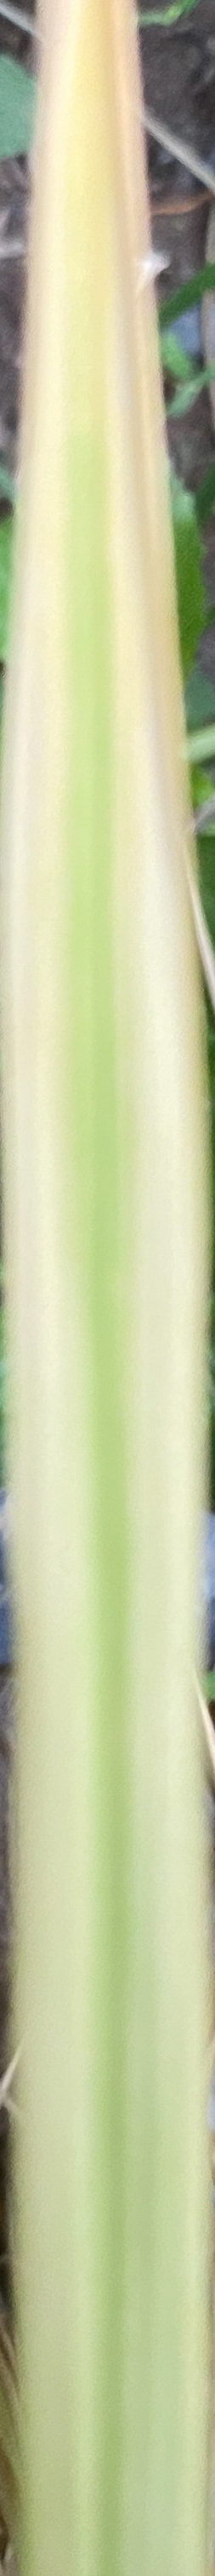

In [ ]:
import PIL
N = list(data_dir.glob('Nitrogen(N)/*'))
PIL.Image.open(str(N[0]))

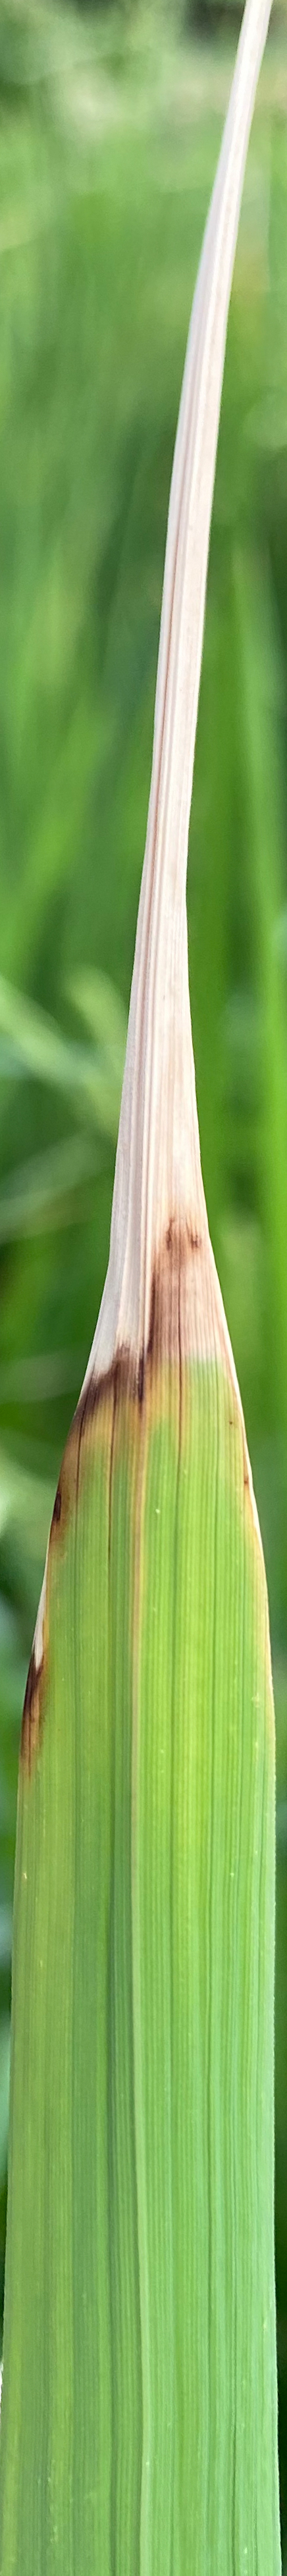

In [ ]:
P = list(data_dir.glob('Phosphorus(P)/*'))
PIL.Image.open(str(P[0]))

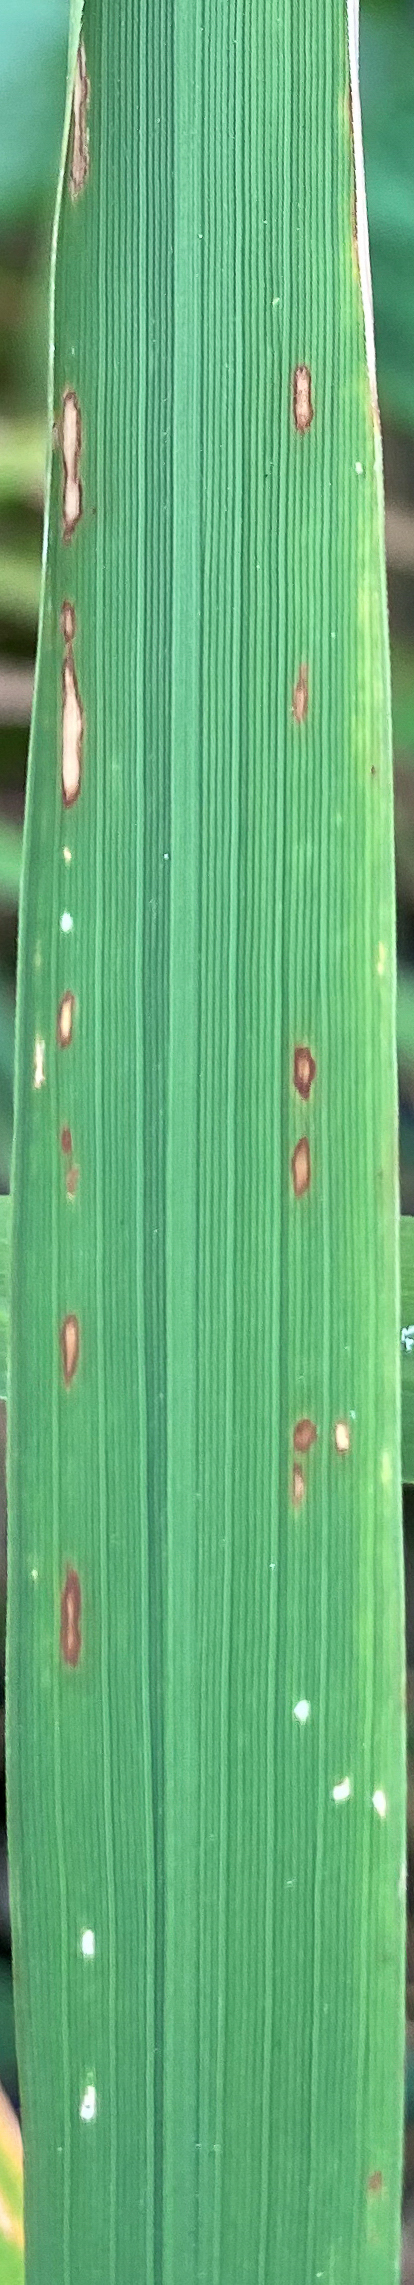

In [ ]:
K = list(data_dir.glob('Potassium(K)/*'))
PIL.Image.open(str(K[0]))

In [ ]:
import cv2
N1 = cv2.imread('/content/Dataset/Nitrogen(N)/untitled-1.JPG')
print(N1.shape)
P1 = cv2.imread('/content/Dataset/Phosphorus(P)/IMG_3784.JPG')
print(P1.shape)
K1 = cv2.imread('/content/Dataset/Potassium(K)/untitled-1.JPG')
print(K1.shape)

(3834, 310, 3)
(3748, 417, 3)
(3796, 471, 3)


## Image Pre-processing

In [ ]:
from pathlib import Path
import cv2

def preprocess(destination_path,target_path):
  format_of_your_images = 'JPG'
  all_the_files = Path(destination_path).rglob(f'*.{format_of_your_images}')
  for f in all_the_files:
    p = cv2.imread(str(f))
    p = cv2.cvtColor(p, cv2.COLOR_BGR2HSV)
    p = cv2.medianBlur(p, 5)
    #  transformation
    cv2.imwrite(f'{target_path}/{f.name}', p)

In [ ]:
destination_path1 = "/content/Dataset/Nitrogen(N)"
target_path1 = "/content/Dataset/Nitrogen(N)"
preprocess(destination_path1, target_path1)

In [ ]:
destination_path2 = "/content/Dataset/Phosphorus(P)"
target_path2 = "/content/Dataset/Phosphorus(P)"
preprocess(destination_path2, target_path2)

In [ ]:
destination_path3 = "/content/Dataset/Potassium(K)"
target_path3 = "/content/Dataset/Potassium(K)"
preprocess(destination_path3, target_path3)

## Data Pre-processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_augment = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.3,
                                  shear_range=0.1,
                                  rotation_range=0,
                                  vertical_flip=True,
                                  horizontal_flip=True,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest',
                                  validation_split=0.2)

In [ ]:
train = data_augment.flow_from_directory(directory=data_dir,
                                         target_size = (256, 256),
                                         batch_size = 64,
                                         class_mode = 'categorical',
                                         shuffle = True,
                                         subset='training')

Found 926 images belonging to 3 classes.


In [ ]:
valid = data_augment.flow_from_directory(directory = data_dir,
                                         target_size = (256, 256),
                                         batch_size = 64,
                                         class_mode = 'categorical',
                                         shuffle = False,
                                         subset='validation')

Found 230 images belonging to 3 classes.


## Models

### Model-1 --> VGG-16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

model1 = VGG16(include_top=False,weights='imagenet',input_shape=(256,256,3))

# Add a new top layer for our classification task
x = model1.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Create a new model with our top layer
model = Model(inputs=model1.input, outputs=predictions)

# Freeze the layers in the base model
for layer in model1.layers:
    layer.trainable = False

# model summary
model.summary()

# Compile the model with a categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train, epochs=30, validation_data=valid)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### Model-2 --> Inception

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

model2 = InceptionV3(include_top=False,weights='imagenet',input_shape=(256,256,3))

# Add a new top layer for our classification task
x = model2.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Create a new model with our top layer
model = Model(inputs=model2.input, outputs=predictions)

# Freeze the layers in the base model
for layer in model2.layers:
    layer.trainable = False

# model summary
model.summary()

# Compile the model with a categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train, epochs=30, validation_data=valid)
model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                  

### Model-3 --> Resnet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256, 3))

# Add a new top layer for our classification task
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Create a new model with our top layer
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# model summary
model.summary()

# Compile the model with a categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train, epochs=30, validation_data=valid)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Evaluation

In [ ]:
loss, accuracy = model.evaluate(valid)

4/4 [==============================] - 9s 2s/step - loss: 1.2955 - accuracy: 0.7478


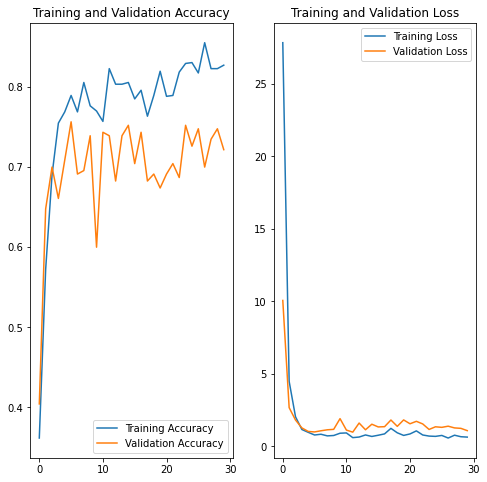

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Y_pred = model.predict(valid)
y_pred = np.argmax(Y_pred, axis=1)

4/4 [==============================] - 10s 2s/step


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']
print(classification_report(valid.classes, y_pred, target_names=target_names))

               precision    recall  f1-score   support

  Nitrogen(N)       0.79      0.74      0.76        88
Phosphorus(P)       0.55      0.70      0.61        66
 Potassium(K)       0.70      0.59      0.64        76

     accuracy                           0.68       230
    macro avg       0.68      0.68      0.67       230
 weighted avg       0.69      0.68      0.68       230



In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import sklearn.metrics
target_names = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']
print(confusion_matrix(valid.classes, y_pred))#, target_names=target_names))

[[65 15  8]
 [ 9 46 11]
 [ 8 23 45]]


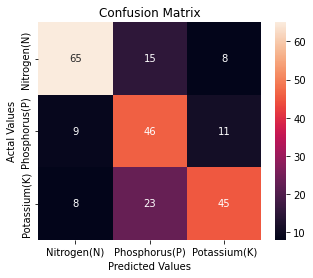

In [ ]:
import seaborn as sns
cm = confusion_matrix(valid.classes, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)'],
                     columns = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Summary


VGG-16   =  loss: 0.8699 - accuracy: 0.6304  
Inception =  loss: 1.2955 - accuracy: 0.7478  
Resnet50 = loss: 1.3374 - accuracy: 0.4826
